In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# https://udemy.com/recommender-systems
# https://deeplearningcourses.com/recommender-systems
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future
import os
import pickle
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten, Concatenate, Dense, Activation, Dropout, BatchNormalization, Lambda, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from keras_tuner import RandomSearch, Hyperband

from sklearn.model_selection import StratifiedKFold

In [ ]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.2 MB/s eta 0:00:00


# Load data

In [ ]:
path = '/content/drive/MyDrive/Recommendation/'
df_process = pd.read_csv(path + "train_negative_dns_fast.csv")

In [ ]:
df_process.columns

Index(['new_customer_code', 'new_sku', 'purchase_dummy'], dtype='object')

In [ ]:
df_process.purchase_dummy.value_counts()

1    2790268
0    2790268
Name: purchase_dummy, dtype: int64

## Số lượng customer và item trong tập train

In [ ]:
N = df_process.new_customer_code.max() + 1
N

27699

In [ ]:
M = df_process.new_sku.max() + 1
M

14398

In [ ]:
len(df_process)

5580536

## Load tập train và test

In [ ]:
# Lấy mẫu ngẫu nhiên
df_process = shuffle(df_process)
cutoff = int(0.8*len(df_process))
df_train = df_process.iloc[:cutoff]
df_test = df_process.iloc[cutoff:]

In [ ]:
# Lấy mẫu với tỷ lệ phân phối giống nhau
from sklearn.model_selection import StratifiedShuffleSplit


X = df_process.drop(columns=["purchase_dummy"])
y = df_process["purchase_dummy"]

# Create an instance of StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into train and test sets
for train_idx, test_idx in ss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Concatenate X_train and y_train
df_train = pd.concat([X_train, y_train], axis=1)

# Concatenate X_test and y_test
df_test = pd.concat([X_test, y_test], axis=1)

# Load check point

In [ ]:
path_check_point = '/content/drive/MyDrive/Recommendation/checkpoint/'
os.makedirs(path_check_point, exist_ok=True)

# Cài đặt model

## Cấu trúc model

### Model 1: NeuMF + Random sampling

In [ ]:
# Load your dataset here
# Ensure your dataset contains user_id, item_id, and binary_rating columns
# Positive samples should have a binary_rating of 1, and negative samples should have a binary_rating of 0

# Split the dataset into training and testing sets
train_data = df_train
test_data = df_test

# Set the number of unique users and items
n_users = N
n_items = M

# Model hyperparameters
n_latent_factors = 8
reg_penalty = 0


# Define the input layers
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

# Create user and item embeddings
user_embedding = Embedding(n_users, n_latent_factors, embeddings_regularizer=l2(reg_penalty))(user_input)
item_embedding = Embedding(n_items, n_latent_factors, embeddings_regularizer=l2(reg_penalty))(item_input)

# Tạo user và item cho NN
user_embedding_nn = Embedding(n_users, n_latent_factors, embeddings_regularizer=l2(reg_penalty))(user_input)
item_embedding_nn = Embedding(n_items, n_latent_factors, embeddings_regularizer=l2(reg_penalty))(item_input)

# Flatten the embeddings
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

# Flatten cho embeddings NN
user_vec_nn = Flatten()(user_embedding_nn)
item_vec_nn = Flatten()(item_embedding_nn)

# Compute the dot product between user and item vectors
y = Dot(axes=1)([user_vec, item_vec])


# Concate hai vector user và item NN
x = Concatenate(axis=1)([user_vec_nn,item_vec_nn])
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)


# Kết hợp MF và NN
y = Concatenate(axis=1)([y,x])

# Chuyển output thành dạng sigmoid
y = Dense(1, activation='sigmoid')(y)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
fname = os.path.sep.join([path_check_point, "weights-{epoch:03d}-{val_loss:.4f}.hdf5"])
checkpoint = ModelCheckpoint(fname, monitor="val_loss", mode="max",save_best_only=True, verbose=3)

# Define the model
model = Model(inputs=[user_input, item_input], outputs=y)
model.compile(#optimizer='adam', 
              optimizer=Adam(learning_rate=0.005),
              # optimizer=SGD(learning_rate=0.005, momentum=0.7),
              loss='binary_crossentropy', 
              metrics=['accuracy'])


### Model 2: MF + DNS sampling

In [ ]:
class MatrixFactorization:
    def __init__(self, userCount = None, itemCount = None, n_latent_factors = 10, reg_penalty = 0.0, epochCount = 20, validationRatio = 0.2, batchSize = 256, openBias = False):
        self.n_latent_factors = n_latent_factors
        self.reg_penalty = reg_penalty
        self.userCount = userCount
        self.itemCount = itemCount
        self.epochCount = epochCount
        self.validationRatio = validationRatio
        self.batchSize = batchSize
        self.openBias = openBias
        self.build()

    def build(self):
        self.user_input = Input(shape=(1,), dtype = "int32")
        self.item_input = Input(shape=(1,), dtype = "int32")
        
        self.user_embedding = Embedding(self.userCount, self.n_latent_factors, embeddings_regularizer=l2(self.reg_penalty))(self.user_input)
        self.item_embedding = Embedding(self.itemCount, self.n_latent_factors, embeddings_regularizer=l2(self.reg_penalty))(self.item_input)

        self.user_vec = Flatten()(self.user_embedding)
        self.item_vec = Flatten()(self.item_embedding)

        # Tính dot product sẽ dựa theo phần tử cuối cùng, tức phần chứa latent factors vector
        self.dot = Dot(axes=1)([self.user_vec, self.item_vec])


        if self.openBias:
            self.user_bias = Embedding(self.userCount, 1, embeddings_regularizer=l2(self.reg_penalty))(self.user_input) # (N, 1, 1)
            self.item_bias = Embedding(self.itemCount, 1, embeddings_regularizer=l2(self.reg_penalty))(self.item_input) # (M, 1, 1)


            self.user_bias_vec = Flatten()(self.user_bias)
            self.item_bias_vec = Flatten()(self.item_bias)

            self.y = Add()([self.dot, self.user_bias_vec, self.item_bias_vec])

            self.y = Activation('sigmoid')(self.y)

            self.model = Model(inputs=[self.user_input, self.item_input], outputs=self.y)
        else:
            self.y = Activation('sigmoid')(self.dot)
            self.model = Model(inputs=[self.user_input, self.item_input], outputs=self.y)

        self.model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['mse']);


    def fit(self, dataTrain):
        # Tập data train cần được shuffle trước khi đem đi train
        shuffle(dataTrain)
        userMatrix = dataTrain.iloc[:, 0].values.reshape(-1, 1).astype(int)
        itemMatrix = dataTrain.iloc[:, 1].values.reshape(-1, 1).astype(int)
        labelMatrix = dataTrain.iloc[:, 2].values.reshape(-1, 1).astype(int)

        fname = os.path.sep.join([path_check_point, "weights-{epoch:03d}-{val_loss:.4f}.hdf5"])
        checkpoint = ModelCheckpoint(fname, monitor="val_loss", mode="min",save_best_only=True, verbose=3)
        self.result = self.model.fit([userMatrix, itemMatrix], labelMatrix, epochs = self.epochCount, batch_size = self.batchSize,
                    validation_split = self.validationRatio, callbacks = [EarlyStopping(mode = "min",verbose=1, patience=1),checkpoint]);

In [ ]:
model = MatrixFactorization(userCount=N, itemCount=M,n_latent_factors=32, epochCount=4,openBias=True)
model.fit(df_process)

Epoch 1/4
17438/17440 [============================>.] - ETA: 0s - loss: 0.6546 - mse: 0.2317
Epoch 1: val_loss improved from inf to 0.63312, saving model to /content/drive/MyDrive/Recommendation/checkpoint/weights-001-0.6331.hdf5
17440/17440 [==============================] - 86s 5ms/step - loss: 0.6546 - mse: 0.2317 - val_loss: 0.6331 - val_mse: 0.2220
Epoch 2/4
17440/17440 [==============================] - ETA: 0s - loss: 0.5943 - mse: 0.2046
Epoch 2: val_loss improved from 0.63312 to 0.61788, saving model to /content/drive/MyDrive/Recommendation/checkpoint/weights-002-0.6179.hdf5
17440/17440 [==============================] - 73s 4ms/step - loss: 0.5943 - mse: 0.2046 - val_loss: 0.6179 - val_mse: 0.2150
Epoch 3/4
17427/17440 [============================>.] - ETA: 0s - loss: 0.5403 - mse: 0.1815
Epoch 3: val_loss did not improve from 0.61788
17440/17440 [==============================] - 75s 4ms/step - loss: 0.5403 - mse: 0.1815 - val_loss: 0.6257 - val_mse: 0.2173
Epoch 3: early 

In [ ]:
np.ones((df_process.shape[0], 1))

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

## Trực quan hóa model

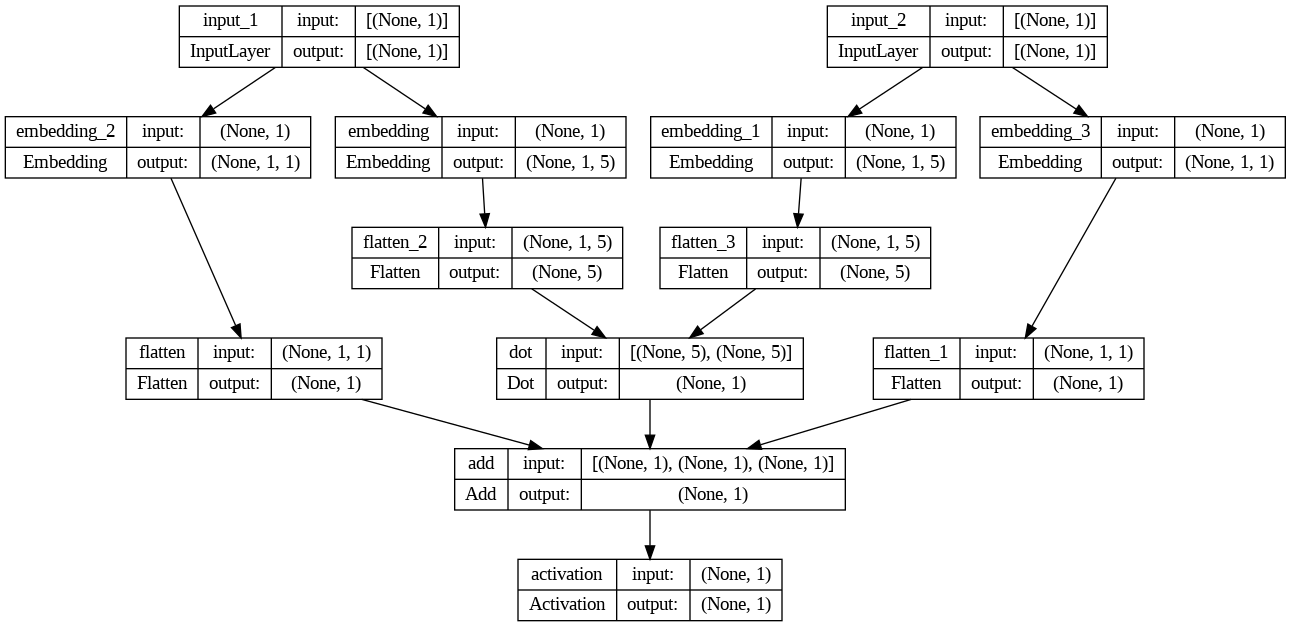

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Bắt đầu training

In [ ]:
model.history.history

{'loss': [0.654555082321167, 0.5943127870559692, 0.5402981042861938],
 'mse': [0.2317075878381729, 0.2045578807592392, 0.1815241575241089],
 'val_loss': [0.6331169605255127, 0.6178783178329468, 0.6256745457649231],
 'val_mse': [0.22198939323425293, 0.2149628847837448, 0.21725133061408997]}

In [ ]:
# Train the model
r = model.fit(
    [train_data['new_customer_code'].values, train_data['new_sku'].values],
    train_data['purchase_dummy'].values,
    batch_size=64,
    epochs=8,
    callbacks=[early_stop, checkpoint],
    validation_data=(
        [test_data['new_customer_code'].values, test_data['new_sku'].values],
        test_data['purchase_dummy'].values
    )
)

## Hiển thị plot loss

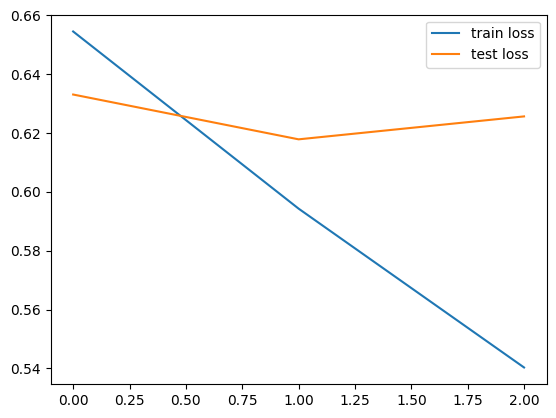

In [ ]:
# plot losses
plt.plot(model.history.history['loss'], label="train loss")
plt.plot(model.history.history['val_loss'], label="test loss")
plt.legend()
plt.show()

## Save model

In [ ]:
path1 = '/content/drive/MyDrive/Recommendation system/Project/Negative/store/'
model.save(path1+ 'v2_model_new_MF_2023_04_13.h5')  

AttributeError: ignored

## Load model

In [ ]:
path1 = '/content/drive/MyDrive/Recommendation/store/'
model = load_model(path1 +'weights-001-0.4394.hdf5')

# Pretrain model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras_tuner.tuners import Hyperband

train_data = df_train
test_data = df_test
early_stop = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=3)

model.fit(
    [train_data['new_customer_code'].values, train_data['new_sku'].values],
    train_data['purchase_dummy'].values,
    batch_size=128,
    epochs=3,
    callbacks=[early_stop],
    validation_data=(
        [test_data['new_customer_code'].values, test_data['new_sku'].values],
        test_data['purchase_dummy'].values
    )
)

In [ ]:
path1 = '/content/drive/MyDrive/Recommendation/store/'
model.save(path1+ 'weights-001-0.4394_pretrain.hdf5')  

# Kiểm tra hiệu suất model

## Các def hỗ trợ kiểm tra

### Precision và Recall

In [ ]:
def mean_precision_recall_at_k(predictions_dict, k=10):
    precisions = []
    recalls = []
    true_items = []
    
    for uid, user_ratings in predictions_dict.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r == 1) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= 0.5) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r == 1) and (est >= 0.5)) for (est, true_r) in user_ratings[:k])

        precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1)
        recalls.append(n_rel_and_rec_k / n_rel if n_rel != 0 else 1)
        true_items.append(n_rel)


    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    true_items = np.mean(true_items)

    return mean_precision, mean_recall, true_items

### DCG và MRR

In [ ]:
from collections import defaultdict
import numpy as np
from sklearn.metrics import ndcg_score
def average_ndcg(predictions_dict, k=10):
    ndcg_scores = []
    for uid, user_ratings in predictions_dict.items():
        true_ratings = [r for (_, r) in user_ratings]
        est_ratings = [est for (est, _) in user_ratings]
        ndcg_scores.append(ndcg_score([true_ratings], [est_ratings], k=k))
    return np.mean(ndcg_scores)



def mean_reciprocal_rank(predictions):
    mrr_scores = []
    for uid, user_ratings in predictions.items():
        true_ratings = [true_r for (_, true_r) in user_ratings]
        est_ratings = [est for (est, _) in user_ratings]
        ranks = [idx + 1 for idx, (est, true_r) in enumerate(zip(est_ratings, true_ratings)) if est >= 0.5 and true_r == 1]
        mrr_scores.append(1 / ranks[0] if ranks else 0)
    return np.mean(mrr_scores)

### Hit Rate

In [ ]:
def hit_rate(predictions_dict, k=10):
    num_users = len(predictions_dict)
    hits = 0
    for uid, user_ratings in predictions_dict.items():
        if any(true_r == 1 for (_, true_r) in user_ratings[:k]):
            hits += 1
    hr_metric = round(hits / num_users,3)
    return hr_metric

## Triển khai

### Load data test

In [ ]:
# dataset_test_negative_x10_easy.csv
# dataset_test_negative_x15.csv
# dataset_test_negative_x20.csv
# HR_test_dataset_in_2023_prohability.csv
# HR_test_dataset_in_2023
path_combine = '/content/drive/MyDrive/Recommendation/'
test_combined = pd.read_csv(path_combine + "HR_test_dataset_in_2023.csv")
test_combined

### Load model

In [ ]:
path1 = '/content/drive/MyDrive/Recommendation/store/'
model_penalty = load_model(path1 +'weights-002-0.6564.hdf5')

### Chạy kiểm tra

In [ ]:
# Chạy model predict
test_user_ids = test_combined['new_customer_code'].values
test_item_ids = test_combined['new_sku'].values
test_binary_ratings = test_combined['purchase_dummy'].apply(lambda x: 1 if x > 0 else 0).values

predictions = model_penalty.predict([test_user_ids, test_item_ids])

In [ ]:
# Chạy kiểm tra các metric
from collections import defaultdict
# Prepare the predictions dictionary
predictions_dict = defaultdict(list)
for uid, iid, true_r, est in zip(test_user_ids, test_item_ids, test_binary_ratings, predictions.flatten()):
    predictions_dict[uid].append((est, true_r))

# Sort user_ratings by estimated ratings in descending order
for uid, user_ratings in predictions_dict.items():
    predictions_dict[uid] = sorted(user_ratings, key=lambda x: x[0], reverse=True)

# Calculate evaluation metrics
# mean_precision, mean_recall, true_items = mean_precision_recall_at_k(predictions_dict, k=10)
hr = hit_rate(predictions_dict)
ndcg = average_ndcg(predictions_dict, 10)
rrank = mean_reciprocal_rank(predictions_dict)
# mean_items = true_items

# print(f"Mean Precision@10: {mean_precision:.4f}")
# print(f"Mean Recall@10: {mean_recall:.4f}")
# print(f"Mean Items: {mean_items:.4f}")

print("Hit Rate @10: ", hr)
print(f"Mean_ndcg_at_k@10: {ndcg:.4f}")
print(f"Mean_reciprocal_rank@10: {rrank:.4f}")